# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tempfile
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

from io import BytesIO
from PIL import Image

from helpers import make_geoplot, make_market_plot, make_market_deep_dive_plot

In [3]:
# Initialize R instance
r = robjects.r

In [4]:
# Install the GeoLift package
r('''
if (!require("GeoLift")) {
    install.packages("GeoLift", repos="http://cran.us.r-project.org")
    library(GeoLift)
}
''')

R[write to console]: Loading required package: GeoLift



# Single-Cell GeoLift Planning & Analysis

>Code based on walkthrough: https://facebookincubator.github.io/GeoLift/docs/GettingStarted/Walkthrough

## Load Data

In [5]:
r('''
data(GeoLift_PreTest)
''')

In [6]:
r('''
GeoTestData_PreTest <- GeoDataRead(data = GeoLift_PreTest,
                                        date_id = "date",
                                        location_id = "location",
                                        Y_id = "Y",
                                        X = c(), #empty list as we have no covariates
                                        format = "yyyy-mm-dd",
                                        summary = TRUE)
''')

R[write to console]: ##################################
#####       Summary       #####
##################################

* Raw Number of Locations: 40
* Time Periods: 90
* Final Number of Locations (Complete): 40



### Data from CSV

In [7]:
# # Step 1: Load Data
# with localconverter(robjects.default_converter + pandas2ri.converter):
#     geo_data = robjects.conversion.py2rpy(pd.read_csv('gt-sample.csv'))

#     r.assign('geo_data', geo_data)

In [8]:
# r('''
# GeoTestData_PreTest <- GeoDataRead(data = geo_data,
#                                         date_id = "date",
#                                         location_id = "location",
#                                         Y_id = "subs",
#                                         X = c(), #empty list as we have no covariates
#                                         format = "yyyy-mm-dd",
#                                         summary = TRUE)
# ''')

## Inspect Data

In [9]:
# Step 2: Pre-Analysis
r('''
print(head(GeoTestData_PreTest))
''')

  location time    Y
1  atlanta    1 3384
2  atlanta    2 3904
3  atlanta    3 5734
4  atlanta    4 4311
5  atlanta    5 3686
6  atlanta    6 3374


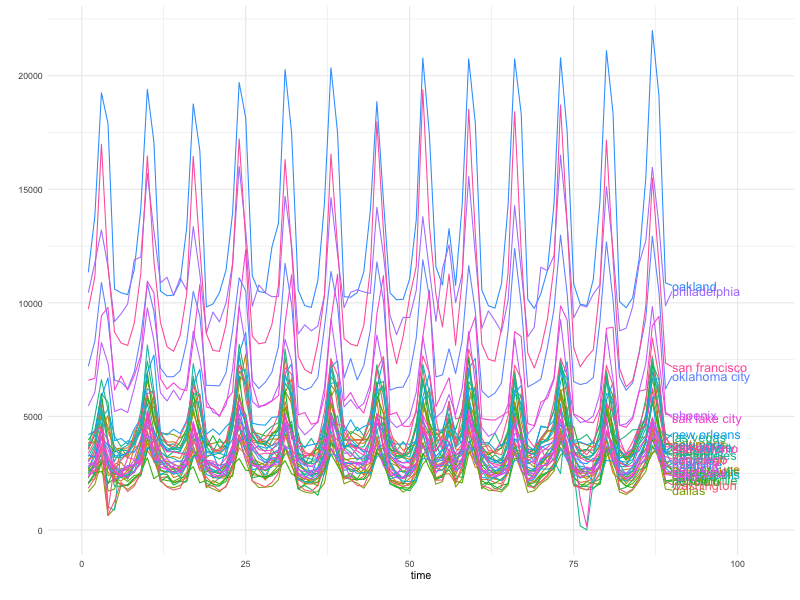

In [11]:
f = '''
GeoPlot(GeoTestData_PreTest,
                   Y_id = "Y",
                   time_id = "time",
                   location_id = "location")
'''

make_geoplot(r, f)

## Planning: Power Analysis

In [12]:
# parameters documentation: 
# https://facebookincubator.github.io/GeoLift/docs/GettingStarted/Walkthrough#2-power-analysis

r('''
    MarketSelections <- GeoLiftMarketSelection(data = GeoTestData_PreTest,
                                              treatment_periods = c(10,15),
                                              N = c(2,3,4,5),
                                              Y_id = "Y",
                                              location_id = "location",
                                              time_id = "time",
                                              effect_size = seq(0, 0.5, 0.05),
                                              lookback_window = 1,
                                              include_markets = c("chicago"),
                                              exclude_markets = c("honolulu"),
                                              holdout = c(0.5, 1),
                                              cpic = 7.50,
                                              budget = 100000,
                                              alpha = 0.1,
                                              Correlations = TRUE,
                                              fixed_effects = TRUE,
                                              side_of_test = "two_sided")
''')

R[write to console]: Setting up cluster.

R[write to console]: Importing functions into cluster.

R[write to console]: Attempting to load the environment ‘package:dplyr’

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Calculating which the best treatment groups are.

R[write to console]: 
Deterministic setup with 2 locations in treatment.

R[write to console]: 
Deterministic setup with 3 locations in treatment.

R[write to console]: 
Deterministic setup with 4 locations in treatment.

R[write to console]: 
Deterministic setup with 5 locations in treatment.



  ID                                           location duration EffectSize
1  1             chicago, cincinnati, houston, portland       15       0.05
2  2                                  chicago, portland       15       0.10
3  3             chicago, cincinnati, houston, portland       10       0.10
4  4                                  chicago, portland       10       0.10
5  5                         chicago, houston, portland       10       0.10
6  6 chicago, cincinnati, houston, nashville, san diego       15       0.05
  Power AvgScaledL2Imbalance Investment   AvgATT Average_MDE ProportionTotal_Y
1     1            0.1971864   74118.38 159.3627  0.04829913        0.07576405
2     1            0.1738778   64563.75 290.0071  0.10117316        0.03306537
3     1            0.1966996   99027.75 316.6203  0.09552878        0.07576405
4     1            0.1682310   43646.25 300.9401  0.10378013        0.03306537
5     1            0.2305628   75389.25 350.3142  0.10502968        0.057

R[write to console]: ##################################
#####   GeoLift Simulation   #####
####  Simulating: 5% Lift  ####
##################################

R[write to console]: 
GeoLift Results Summary


R[write to console]: ##################################
#####     Test Statistics    #####
##################################

* Average ATT: 159.363
* Percent Lift: 4.8%
* Incremental Y: 9562
* P-value: 0.07

##################################
#####   Balance Statistics   #####
##################################

* L2 Imbalance: 948.101
* Scaled L2 Imbalance: 0.1972
* Percent improvement from naive model: 80.28%
* Average Estimated Bias: NA

##################################
#####     Model Weights      #####
##################################

* Prognostic Function: NONE

* Model Weights:

R[write to console]:  * baton rouge: 0.217

R[write to console]:  * nashville: 0.1883

R[write to console]:  * miami: 0.1635

R[write to console]:  * san diego: 0.1324

R[write to console]:  * 

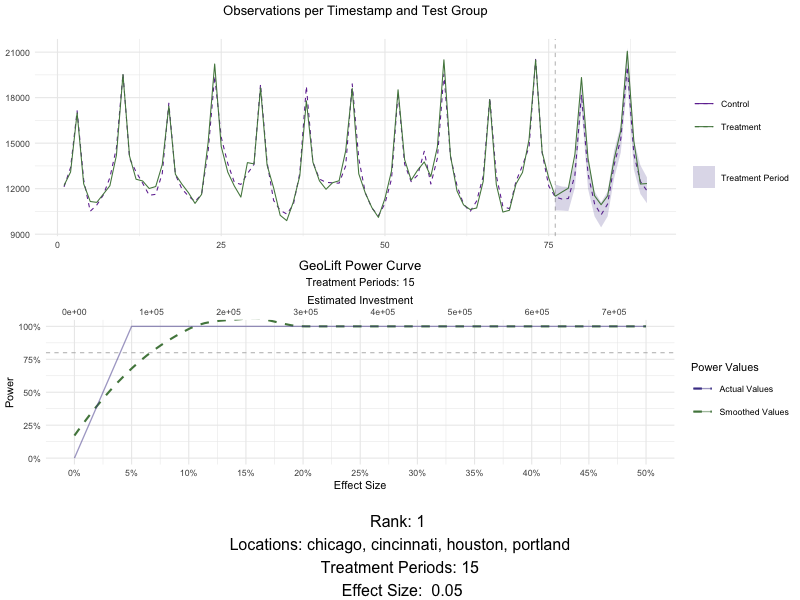

In [14]:
# Plot for chicago, cincinnati, houston, portland for a 15 day test
make_market_plot(r, 1)

R[write to console]: Setting up cluster.

R[write to console]: Importing functions into cluster.

R[write to console]: Calculating Power for the following treatment group: chicago; portland.



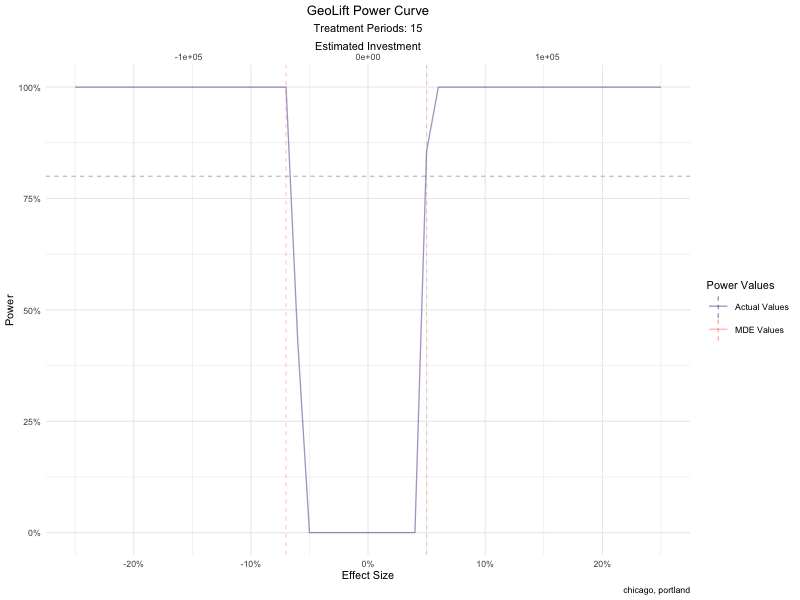

In [17]:
# Plot for Chicago and Portland (2) with 7 day lookback
make_market_deep_dive_plot(r, 2, 7)

In [18]:
r('''
weights <- GetWeights(Y_id = "Y",
                          location_id = "location",
                          time_id = "time",
                          data = GeoTestData_PreTest,
                          locations = c("chicago", "portland"),
                          pretreatment_end_time = 90,
                          fixed_effects = TRUE)
''')

R[write to console]: One outcome and one treatment time found. Running single_augsynth.



In [19]:
# Top weights
r('''
print(head(dplyr::arrange(weights, desc(weight)), 10))
''')

      location     weight
1   cincinnati 0.22717797
2        miami 0.20276981
3  baton rouge 0.13353743
4  minneapolis 0.08997973
5       dallas 0.07392298
6    nashville 0.06853184
7     honolulu 0.06726036
8       austin 0.04652520
9    san diego 0.04507275
10        reno 0.03062703


## Test Results Analysis

In [20]:
r('''
data(GeoLift_Test)
''')

In [21]:
r('''
print(tail(GeoLift_Test))
''')

       location    Y       date
4195 saint paul 2746 2021-04-10
4196 saint paul  151 2021-04-11
4197 saint paul  114 2021-04-12
4198 saint paul 3264 2021-04-13
4199 saint paul 2481 2021-04-14
4200 saint paul 2631 2021-04-15


In [22]:
r('''
GeoTestData_Test <- GeoDataRead(data = GeoLift_Test,
                                        date_id = "date",
                                        location_id = "location",
                                        Y_id = "Y",
                                        X = c(), #empty list as we have no covariates
                                        format = "yyyy-mm-dd",
                                        summary = TRUE)
''')

R[write to console]: ##################################
#####       Summary       #####
##################################

* Raw Number of Locations: 40
* Time Periods: 105
* Final Number of Locations (Complete): 40



In [23]:
r('''
print(tail(GeoTestData_Test))
''')

       location time    Y
4195 washington  100 2895
4196 washington  101 4351
4197 washington  102 4178
4198 washington  103 2392
4199 washington  104 1909
4200 washington  105 1805


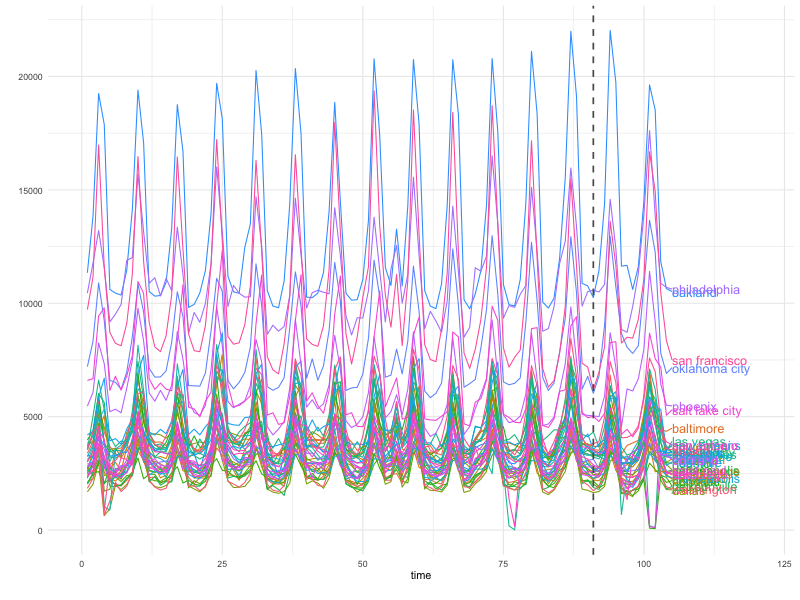

In [24]:
f = '''
GeoPlot(GeoTestData_Test,
        Y_id = "Y",
        time_id = "time",
        location_id = "location",
        treatment_start = 91)
'''

make_geoplot(r, f)

In [25]:
# GeoLift Inference - calculate actual Lift
# https://facebookincubator.github.io/GeoLift/docs/GettingStarted/Walkthrough#geolift-inference
r('''
GeoTest <- GeoLift(Y_id = "Y",
                        data = GeoTestData_Test,
                        locations = c("chicago", "portland"),
                        treatment_start_time = 91,
                        treatment_end_time = 105)
''')

In [26]:
r('''
print(GeoTest)
''')

R[write to console]: 
GeoLift Output

Test results for 15 treatment periods, from time-stamp 91 to 105 for test markets:

R[write to console]: 1 CHICAGO

R[write to console]: 2 PORTLAND

R[write to console]: ##################################
#####     Test Statistics    #####
##################################

Percent Lift: 5.4%

Incremental Y: 4667

Average Estimated Treatment Effect (ATT): 155.556

The results are significant at a 95% level. (TWO-SIDED LIFT TEST)

There is a 0.3% chance of observing an effect this large or larger assuming treatment effect is zero.



In [27]:
r('''
print(summary(GeoTest))
''')

R[write to console]: 
GeoLift Results Summary


R[write to console]: ##################################
#####     Test Statistics    #####
##################################

* Average ATT: 155.556
* Percent Lift: 5.4%
* Incremental Y: 4667
* P-value: 0

##################################
#####   Balance Statistics   #####
##################################

* L2 Imbalance: 909.489
* Scaled L2 Imbalance: 0.1636
* Percent improvement from naive model: 83.64%
* Average Estimated Bias: NA

##################################
#####     Model Weights      #####
##################################

* Prognostic Function: NONE

* Model Weights:

R[write to console]:  * cincinnati: 0.2272

R[write to console]:  * miami: 0.2028

R[write to console]:  * baton rouge: 0.1335

R[write to console]:  * minneapolis: 0.09

R[write to console]:  * dallas: 0.0739

R[write to console]:  * nashville: 0.0685

R[write to console]:  * honolulu: 0.0673

R[write to console]:  * austin: 0.0465

R[write to console]

R[write to console]: You can include dates in your chart if you supply the end date of the treatment. Just specify the treatment_end_date parameter.



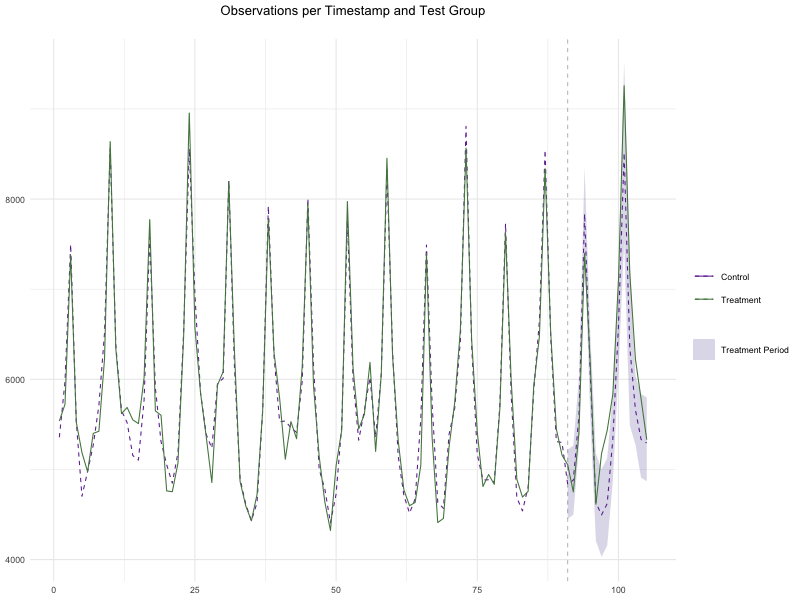

In [28]:
# can include dates in chart by giving end date of treatment, pass arg treatment_end_date='yyyy-mm-dd'
f='''
plot(GeoTest, type = "Lift")
'''
make_geoplot(r, f)

R[write to console]: You can include dates in your chart if you supply the end date of the treatment. Just specify the treatment_end_date parameter.



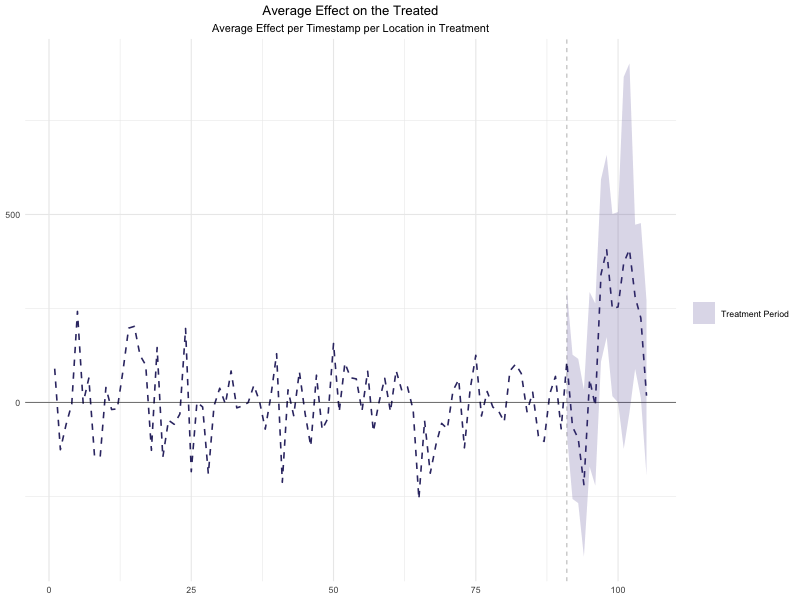

In [29]:
# can include dates in chart by giving end date of treatment, pass arg treatment_end_date='yyyy-mm-dd'
f='''
plot(GeoTest, type = "ATT")
'''
make_geoplot(r, f)

### Improving the Model

>While the results obtained from the test are robust and highly significant, a useful feature of GeoLift is its ability to improve the model fit even further and reduce bias through augmentation by a prognostic function. There are several options for augmentation of the standard GeoLift model such as regularization (specifically Ridge) and an application of Generalized Synthetic Control Model (GSC). While each of these approaches provide it’s own set of advantages, for instance Ridge regularization usually performs well when the number of units and time-periods isn’t large while GSC helps improve fit for situations with many pre-treatment periods, GeoLift offers the option to let the model decide which is the best approach by setting the model parameter to “best”. (https://facebookincubator.github.io/GeoLift/docs/GettingStarted/Walkthrough#improving-the-model)

In [30]:
r('''
    GeoTestBest <- GeoLift(Y_id = "Y",
                            data = GeoTestData_Test,
                            locations = c("chicago", "portland"),
                            treatment_start_time = 91,
                            treatment_end_time = 105,
                            model = "best")
''')

R[write to console]: Selected Ridge as best model.



In [31]:
r('''
print(GeoTestBest)
''')

R[write to console]: 
GeoLift Output

Test results for 15 treatment periods, from time-stamp 91 to 105 for test markets:

R[write to console]: 1 CHICAGO

R[write to console]: 2 PORTLAND

R[write to console]: ##################################
#####     Test Statistics    #####
##################################

Percent Lift: 5.5%

Incremental Y: 4704

Average Estimated Treatment Effect (ATT): 156.805

The results are significant at a 95% level. (TWO-SIDED LIFT TEST)

There is a 1% chance of observing an effect this large or larger assuming treatment effect is zero.



In [32]:
r('''
print(summary(GeoTestBest))
''')

R[write to console]: 
GeoLift Results Summary


R[write to console]: ##################################
#####     Test Statistics    #####
##################################

* Average ATT: 156.805
* Percent Lift: 5.5%
* Incremental Y: 4704
* P-value: 0.01

##################################
#####   Balance Statistics   #####
##################################

* L2 Imbalance: 903.525
* Scaled L2 Imbalance: 0.1626
* Percent improvement from naive model: 83.74%
* Average Estimated Bias: -1.249

##################################
#####     Model Weights      #####
##################################

* Prognostic Function: RIDGE

* Model Weights:

R[write to console]:  * cincinnati: 0.2273

R[write to console]:  * miami: 0.2029

R[write to console]:  * baton rouge: 0.1337

R[write to console]:  * minneapolis: 0.0901

R[write to console]:  * dallas: 0.0741

R[write to console]:  * nashville: 0.0687

R[write to console]:  * honolulu: 0.0674

R[write to console]:  * austin: 0.0467

R[write t

R[write to console]: You can include dates in your chart if you supply the end date of the treatment. Just specify the treatment_end_date parameter.



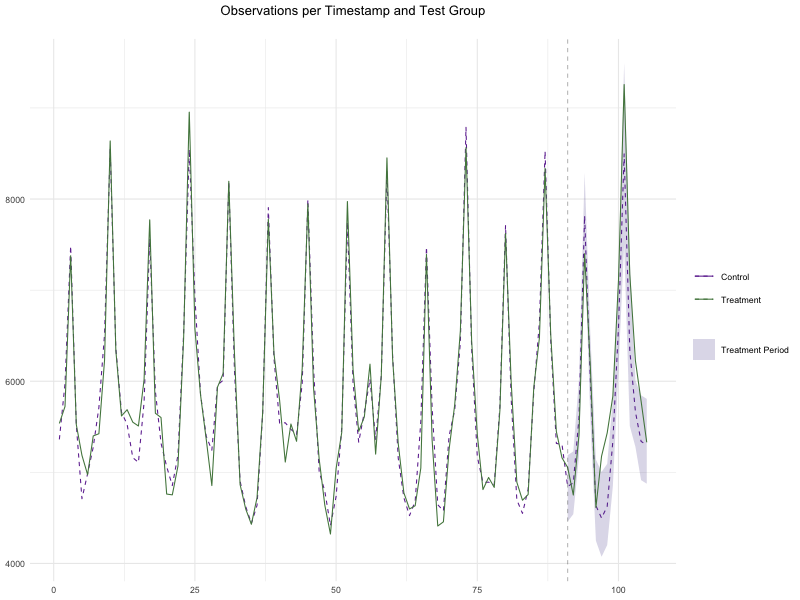

In [33]:
# can include dates in chart by giving end date of treatment, pass arg treatment_end_date='yyyy-mm-dd'
f='''
plot(GeoTestBest, type = "Lift")
'''
make_geoplot(r, f)

R[write to console]: You can include dates in your chart if you supply the end date of the treatment. Just specify the treatment_end_date parameter.



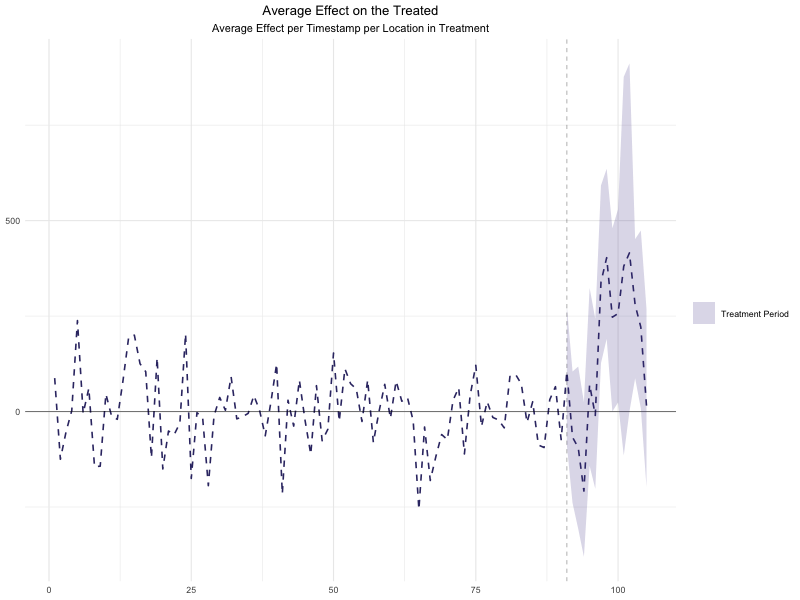

In [34]:
# can include dates in chart by giving end date of treatment, pass arg treatment_end_date='yyyy-mm-dd'
f='''
plot(GeoTestBest, type = "ATT")
'''
make_geoplot(r, f)